# PyTorch Implementation of Fashion MNIST using TinyVGG
* **[TinyVGG](https://poloclub.github.io/cnn-explainer/)**

In [2]:
import torch
import torchvision
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision import datasets , transforms
from tqdm.auto import tqdm
from helper_functions import *

torch.__version__,torchvision.__version__

('2.3.1+cpu', '0.18.1+cpu')

In [3]:
train = datasets.FashionMNIST('data',train = True,
                                download = True,
                                transform = ToTensor(), # converting PIL images into Tensors
                                target_transform=None)
test = datasets.FashionMNIST('data',train = False,
                                download = True,
                                transform = ToTensor(),
                                target_transform=None)

100%|██████████| 26421880/26421880 [14:37<00:00, 30118.21it/s]


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 70985.22it/s]


Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 4422102/4422102 [03:04<00:00, 23939.00it/s]


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<00:00, 14999.91it/s]

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



In [4]:
train,test

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [6]:
classes  = train.classes
train.classes , train.class_to_idx

(['T-shirt/top',
  'Trouser',
  'Pullover',
  'Dress',
  'Coat',
  'Sandal',
  'Shirt',
  'Sneaker',
  'Bag',
  'Ankle boot'],
 {'T-shirt/top': 0,
  'Trouser': 1,
  'Pullover': 2,
  'Dress': 3,
  'Coat': 4,
  'Sandal': 5,
  'Shirt': 6,
  'Sneaker': 7,
  'Bag': 8,
  'Ankle boot': 9})

In [9]:
img , label = train[0]
img.shape , label

(torch.Size([1, 28, 28]), 9)

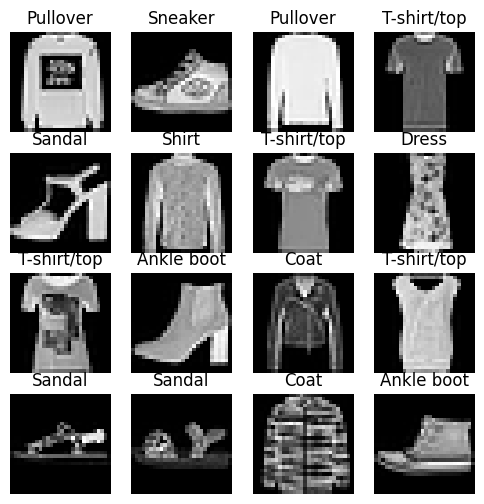

In [10]:
fig = plt.figure(figsize = (6,6))
for a in range(1,17):
  id = torch.randint(0,len(train),size = [1]).item()
  im,lb = train[id]
  fig.add_subplot(4,4,a)
  plt.imshow(im.squeeze(),cmap = 'gray')
  plt.title(classes[lb])
  plt.axis('off')

In [11]:
train = DataLoader(dataset = train , batch_size = 32 , shuffle = True) # shuffling trianing data to remove order, so that model wont expect any specific order
test = DataLoader(dataset = test , batch_size = 32 , shuffle = False)

In [12]:
print(f'Train dataset has {len(train)} Batches of 32')
print(f'Test dataset has {len(test)} Batches of 32')

Train dataset has 1875 Batches of 32
Test dataset has 313 Batches of 32


In [13]:
features , labels = next(iter(train))
features.shape,labels.shape,features[0].shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]), torch.Size([1, 28, 28]))

In [14]:
flatten = nn.Flatten()
flatten(features[0]).shape

torch.Size([1, 784])

In [15]:
def train_fn(model , dataloader_obj_train):

  train_loss,train_acc = 0,0
  model.to(device)
  model.train()
  for batch,(x,y) in enumerate(dataloader_obj_train):
    x, y = x.to(device), y.to(device)
    ypred = model(x)

    loss = loss_fn(ypred,y)

    train_loss += loss
    train_acc += accuracy_fn(y,ypred.argmax(dim=1))

    optim.zero_grad()

    loss.backward()

    optim.step()

  train_loss /= len(dataloader_obj_train)
  train_acc /= len(dataloader_obj_train)
  print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_fn(model,dataloader_obj_test):
  test_loss,test_acc = 0,0
  model.to(device)
  model.eval()

  with torch.inference_mode():
    for xtest,ytest in dataloader_obj_test:
      xtest, ytest = xtest.to(device), ytest.to(device)
      ypredtest = model(xtest)

      test_loss += loss_fn(ypredtest,ytest)
      test_acc += accuracy_fn(ytest,ypredtest.argmax(dim=1))

    test_loss /= len(dataloader_obj_test)
    test_acc /= len(dataloader_obj_test)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%")

### Model

In [16]:
class FashionMnist(nn.Module):
  def __init__(self,inp,hidden,out):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        # in_channels represents the number of channels of images
        # out_channels represents number of filters
        nn.Conv2d(in_channels=inp,out_channels=hidden,kernel_size=3,stride = 1,padding = 1),
        nn.ReLU(),
        nn.Conv2d(hidden,hidden,kernel_size=3,stride = 1,padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2))
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(hidden,hidden,kernel_size=3,stride = 1,padding = 1),
        nn.ReLU(),
        nn.Conv2d(hidden,out,kernel_size=3,stride = 1,padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2))
    self.classifier = nn.Sequential(
        nn.Flatten(), # after Flatten the shape would become from [10, 7, 7] -> [10,49] 
        nn.Linear(490,10))

  def forward(self,x):
    return self.classifier(self.conv_block_2(self.conv_block_1(x)))
    # print(x.shape)
    # x = self.conv_block_1(x)
    # print(x.shape)
    # x = self.conv_block_2(x)
    # print(x.shape)
    # x = self.classifier(x)
    # return x

In [17]:
torch.manual_seed(42)
model = FashionMnist(1,10,10).to(device)
model(img.unsqueeze(dim=1))

tensor([[ 0.0246, -0.0644,  0.0551, -0.0360, -0.0139,  0.0113, -0.0014, -0.0075,
          0.0213,  0.0076]], grad_fn=<AddmmBackward0>)

In [18]:
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(),lr = 0.1)

In [19]:
torch.manual_seed(42)
epochs = 10

for epoch in range(epochs):
  print(f"Epoch: {epoch}\n---------")

  train_fn(model,train)

  test_fn(model,test)

Epoch: 0
---------
Train loss: 0.59190 | Train accuracy: 78.54%
Test loss: 0.39047 | Test accuracy: 86.05%
Epoch: 1
---------
Train loss: 0.36174 | Train accuracy: 87.07%
Test loss: 0.35067 | Test accuracy: 87.10%
Epoch: 2
---------
Train loss: 0.32421 | Train accuracy: 88.18%
Test loss: 0.31687 | Test accuracy: 88.43%
Epoch: 3
---------
Train loss: 0.30365 | Train accuracy: 89.00%
Test loss: 0.32363 | Test accuracy: 88.10%
Epoch: 4
---------
Train loss: 0.29092 | Train accuracy: 89.35%
Test loss: 0.30348 | Test accuracy: 89.29%
Epoch: 5
---------
Train loss: 0.28139 | Train accuracy: 89.75%
Test loss: 0.30629 | Test accuracy: 88.77%
Epoch: 6
---------
Train loss: 0.27340 | Train accuracy: 90.02%
Test loss: 0.30342 | Test accuracy: 88.91%
Epoch: 7
---------
Train loss: 0.26781 | Train accuracy: 90.16%
Test loss: 0.30078 | Test accuracy: 88.79%
Epoch: 8
---------
Train loss: 0.26018 | Train accuracy: 90.41%
Test loss: 0.29449 | Test accuracy: 89.53%
Epoch: 9
---------
Train loss: 0.2551

In [20]:
l = list(test)
i,l = l[150]
for idx in range(0,32):
  print(f'{idx} Image Shape: {i[idx].shape} | Label: {classes[l[idx]]}')

0 Image Shape: torch.Size([1, 28, 28]) | Label: Ankle boot
1 Image Shape: torch.Size([1, 28, 28]) | Label: Ankle boot
2 Image Shape: torch.Size([1, 28, 28]) | Label: Pullover
3 Image Shape: torch.Size([1, 28, 28]) | Label: Shirt
4 Image Shape: torch.Size([1, 28, 28]) | Label: Ankle boot
5 Image Shape: torch.Size([1, 28, 28]) | Label: Bag
6 Image Shape: torch.Size([1, 28, 28]) | Label: Dress
7 Image Shape: torch.Size([1, 28, 28]) | Label: Sandal
8 Image Shape: torch.Size([1, 28, 28]) | Label: Dress
9 Image Shape: torch.Size([1, 28, 28]) | Label: Trouser
10 Image Shape: torch.Size([1, 28, 28]) | Label: Coat
11 Image Shape: torch.Size([1, 28, 28]) | Label: Sandal
12 Image Shape: torch.Size([1, 28, 28]) | Label: T-shirt/top
13 Image Shape: torch.Size([1, 28, 28]) | Label: Trouser
14 Image Shape: torch.Size([1, 28, 28]) | Label: Bag
15 Image Shape: torch.Size([1, 28, 28]) | Label: Sandal
16 Image Shape: torch.Size([1, 28, 28]) | Label: Bag
17 Image Shape: torch.Size([1, 28, 28]) | Label: Sh

In [21]:
torch.softmax(model(i[30].unsqueeze(dim=0)).squeeze(),dim=0).argmax(dim=0)

tensor(9)

In [22]:
predlist = []
model.eval()
with torch.inference_mode():
  for idx in range(0,32):
    pred = model(i[idx].unsqueeze(dim=0))
    hardpred = torch.softmax(pred.squeeze(),dim = 0).argmax(dim=0)
    predlist.append((i[idx],hardpred,l[idx]))
    print(f'Original Class: {classes[l[idx]]} | Predicted Classes: {classes[hardpred]}')

Original Class: Ankle boot | Predicted Classes: Ankle boot
Original Class: Ankle boot | Predicted Classes: Ankle boot
Original Class: Pullover | Predicted Classes: Pullover
Original Class: Shirt | Predicted Classes: T-shirt/top
Original Class: Ankle boot | Predicted Classes: Ankle boot
Original Class: Bag | Predicted Classes: Bag
Original Class: Dress | Predicted Classes: Dress
Original Class: Sandal | Predicted Classes: Sandal
Original Class: Dress | Predicted Classes: Dress
Original Class: Trouser | Predicted Classes: Trouser
Original Class: Coat | Predicted Classes: Coat
Original Class: Sandal | Predicted Classes: Sandal
Original Class: T-shirt/top | Predicted Classes: T-shirt/top
Original Class: Trouser | Predicted Classes: Trouser
Original Class: Bag | Predicted Classes: Bag
Original Class: Sandal | Predicted Classes: Sandal
Original Class: Bag | Predicted Classes: Bag
Original Class: Shirt | Predicted Classes: Coat
Original Class: T-shirt/top | Predicted Classes: T-shirt/top
Orig

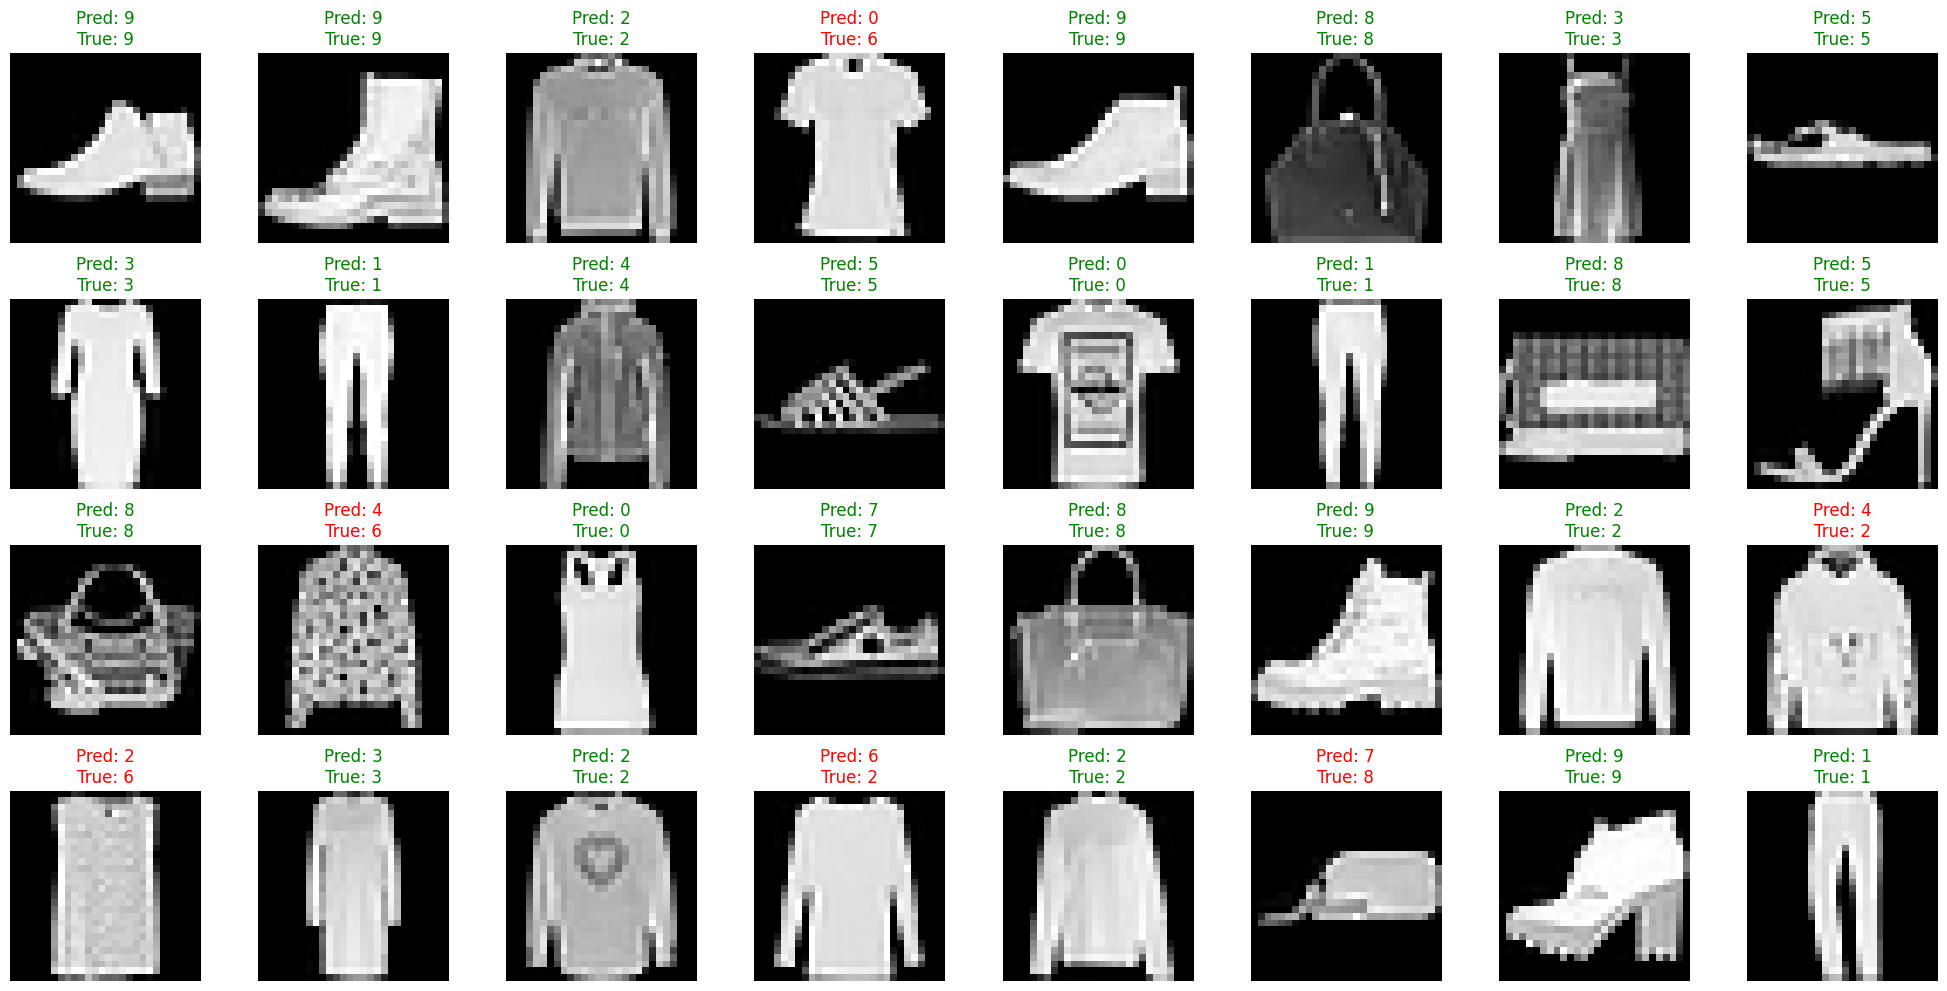

In [23]:
def get_title_color(predicted, true):
    return 'green' if predicted == true else 'red'

fig, axes = plt.subplots(4, 8, figsize=(20, 10))

axes = axes.ravel()

for idx, (img, predicted, true) in enumerate(predlist):
    ax = axes[idx]
    ax.imshow(img.squeeze(), cmap='gray')
    title_color = get_title_color(predicted, true)
    ax.set_title(f'Pred: {predicted}\nTrue: {true}', color=title_color)
    ax.axis('off')

for j in range(len(predlist), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [24]:
torch.save(model,'FashionMnist(TinyVGG).pt')